In [1]:
%cd ../..
%run cryptolytic/notebooks/init.ipynb
import pandas as pd
import tensorflow as tf
import cryptolytic.util as util
import cryptolytic.start as start
import cryptolytic.viz.plot as plot
import cryptolytic.data.sql as sql
import cryptolytic.data as d
from cryptolytic.util import *
import cryptolytic.data.historical as h
import cryptolytic.model as m
import cryptolytic.model.lstm_framework as lstm
import cryptolytic.model.model_framework as mfw
import cryptolytic.model.data_work as dw
import cryptolytic.model.hyperparameter as hyper
import cryptolytic.model.cron_model as cron_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline


import cryptolytic.model.xgboost_model as xtrade
import cryptolytic.model.xgboost_arb_model as xarb
import cryptolytic.data.aws as aws
import pickle
import cryptolytic.start as start
start.init()
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

/home/me/Documents/Git/Lambda-School-Labs/cryptolytic-ds
Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn
sklearn.__version__

'0.22.1'

In [3]:
help(confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=Non

In [4]:
mfw

<module 'cryptolytic.model.model_framework' from '/home/me/Documents/Git/Lambda-School-Labs/cryptolytic-ds/cryptolytic/model/model_framework.py'>

In [5]:
exchange_id = 'hitbtc'
trading_pair = 'btc_usd'
period = 300
start = '03-01-2019'

df, dataset = h.get_data(exchange_id, trading_pair, period, start, n=8000)
preds, score = xtrade.trade_model(df)

[<class 'str'>, <class 'str'>, <class 'int'>, <class 'str'>, <class 'int'>]


/home/me/anaconda3/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning:

invalid value encountered in double_scalars

/home/me/anaconda3/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning:

invalid value encountered in double_scalars

/home/me/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/me/Documents/Git/Lambda-School-Labs/cryptolytic-ds/cryptolytic/model/data_work.py:45: RuntimeWarning:

invalid value encountered i

In [6]:
def my_confusion_matrix(y_test, y_preds):
    # labels for confusion matrix
    unique_y_test = y_test.unique().tolist()
    unique_y_preds = list(set(y_preds))
    labels = list(set(unique_y_test + unique_y_preds))
    labels.sort()
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    cm = confusion_matrix(y_test, y_preds)
    cm = cm / cm.sum(axis=1, keepdims=True)

    # create confusion matrix
    confusion = pd.DataFrame(cm,
                         columns=columns, index=index)
    return confusion


In [7]:
params = {
        'history_size': 400,
        'lahead': 12*3,
        'step': 1,
        'period': 300, # 5 minute candles
        'batch_size': 200,
        'train_size': 10000,
        'ncandles': 5000
}
start = '01-12-2019'

confuses = []
for exchange_id, trading_pair in h.yield_unique_pair(return_api=False):
    
   # model_path = mfw.get_path('models', 'trade', exchange_id, trading_pair, '.pkl')
   # model = pickle.load(open(model_path, 'rb'))
    
    
    df, dataset = h.get_data(exchange_id, trading_pair, params['period'], start, n=params['train_size'])    
    
    #df.drop('volume_adi',axis=1,inplace=True)
    if df is None:
        break

    target = df.columns.get_loc('close')

    # Find the x and y train and test data
    x_train, y_train, x_test, y_test = xtrade.data_splice(df)
    print(x_train)
    # TODO delete
    model = xtrade.create_model()
    model = xtrade.fit_model(model, x_train, y_train)
    y_preds = model.predict(x_test)
    score = accuracy_score(y_test, y_preds)
    confus = my_confusion_matrix(y_test, y_preds)
    confuses.append(confus)
    break

[<class 'str'>, <class 'str'>, <class 'int'>, <class 'str'>, <class 'int'>]


/home/me/anaconda3/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning:

invalid value encountered in double_scalars

/home/me/anaconda3/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning:

invalid value encountered in double_scalars

/home/me/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/me/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning:

invalid value encountered in reduce

/hom

                      timestamp     open    close     high      low  \
datetime                                                              
2019-12-01 10:00:00  1575194400  0.02013  0.02013  0.02015  0.02015   
2019-12-01 11:00:00  1575198000  0.02007  0.02007  0.02007  0.02007   
2019-12-01 11:05:00  1575198300  0.02007  0.02007  0.02007  0.02007   
2019-12-01 13:20:00  1575206400  0.02017  0.02017  0.02017  0.02017   
2019-12-01 13:50:00  1575208200  0.02026  0.02026  0.02026  0.02026   
...                         ...      ...      ...      ...      ...   
2020-01-17 22:45:00  1579301100  0.01923  0.01923  0.01931  0.01931   
2020-01-17 23:00:00  1579302000  0.01923  0.01923  0.01923  0.01923   
2020-01-17 23:45:00  1579304700  0.01921  0.01921  0.01922  0.01922   
2020-01-17 23:55:00  1579305300  0.01922  0.01922  0.01922  0.01922   
2020-01-18 00:00:00  1579305600  0.01915  0.01915  0.01915  0.01915   

                        volume  high_m_low  close_m_open  arb_diff  \
dateti

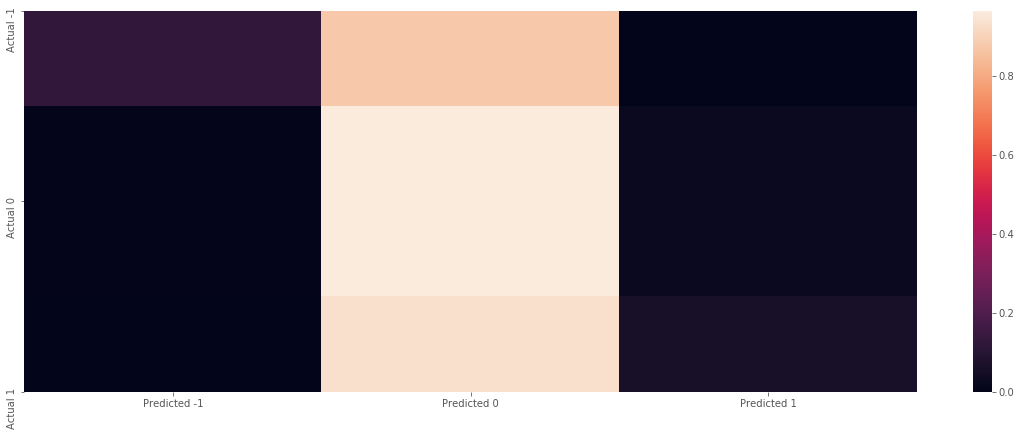

In [8]:
import seaborn as sns
plt.style.use('ggplot')
rcParams['figure.figsize'] = 20,7
for confus in confuses:
    sns.heatmap(confus)
    plt.show()

In [9]:
confuses[0] 

,Predicted -1,Predicted 0,Predicted 1
Actual -1,0.125000,0.87500,0.000000
Actual 0,0.006431,0.96463,0.028939
Actual 1,0.000000,0.93750,0.062500


In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

          -1       0.50      0.12      0.20        16
           0       0.91      0.96      0.94       311
           1       0.10      0.06      0.08        16

    accuracy                           0.88       343
   macro avg       0.50      0.38      0.40       343
weighted avg       0.85      0.88      0.86       343



In [16]:
y_test

datetime
2020-01-18 00:05:00    0
2020-01-18 00:10:00    0
2020-01-18 00:15:00    0
2020-01-18 00:35:00    0
2020-01-18 00:55:00    0
                      ..
2020-01-30 18:45:00    0
2020-01-30 19:15:00    1
2020-01-30 19:20:00    0
2020-01-30 19:40:00    0
2020-01-30 20:10:00    0
Name: price_increased, Length: 343, dtype: int64